## Dataset: Maternal Health Risk

### Licence of use

- That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/863/maternal+health+risk

- licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/


## About the dataset

- The Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.

###  Attributes Description:

- Age - Age in years when a woman is pregnant
- SystolicBP - Upper value of Blood Pressure in mmHg
- DiastolicBP - Lower value of Blood Pressure in mmHg
- BS - Blood glucose levels is in terms of a molar concentration, mmol/L
- BodyTemp - Body temperature in Fahrenheit
- HeartRate - Resting heart rate in beats per minute
- RiskLevel - Predicted Risk Intensity Level during pregnancy ['high risk', 'mid risk', 'low risk']

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### Practical Big Data (PySparkSQL) - Part 1

In [2]:
# Load the libraries
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

In [3]:
# Due the different version of python can be found and each machine or libriries 
# Avoid warnigs
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pyspark
from pyspark.sql import SparkSession

# Criar SparkSession
spark = SparkSession.builder \
    .appName("Análise de Dados de Saúde Materna") \
    .getOrCreate()

In [5]:
# Caminho para o dataset
csv_file = "/user/user1/Maternal_Health_Risk.csv"

# Carregar dados e criar uma visão temporária
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load(csv_file)
df.createOrReplaceTempView("rawdata")

In [6]:
# Visualizar o esquema do DataFrame
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)



# 2. Data Understanding Phase

In [7]:
# Executar uma consulta SQL para selecionar as primeiras 10 linhas da visão temporária
data = spark.sql("SELECT * FROM rawdata LIMIT 10")

# Mostrar os resultados da consulta diretamente
data.show()

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
| 23|       140|         80|7.01|    98.0|       70|high risk|
| 23|       130|         70|7.01|    98.0|       78| mid risk|
| 35|        85|         60|11.0|   102.0|       86|high risk|
| 32|       120|         90| 6.9|    98.0|       70| mid risk|
| 42|       130|         80|18.0|    98.0|       70|high risk|
+---+----------+-----------+----+--------+---------+---------+



In [8]:
# Contar linhas
num_rows = spark.sql("SELECT COUNT(*) as TotalRows FROM rawdata").show()

# Contar colunas usando o DataFrame PySpark (não SQL diretamente)
num_columns = len(df.columns)
print(f"Número de Colunas: {num_columns}")

+---------+
|TotalRows|
+---------+
|     1014|
+---------+

Número de Colunas: 7


In [10]:
from pyspark.sql.functions import col, sum as _sum, when

# Supondo que 'df' seja o seu DataFrame do PySpark
# Listando o número de valores faltantes por coluna
df.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+---+----------+-----------+---+--------+---------+---------+
|Age|SystolicBP|DiastolicBP| BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+---+--------+---------+---------+
|  0|         0|          0|  0|       0|        0|        0|
+---+----------+-----------+---+--------+---------+---------+



In [11]:
# Coletando dados para visualização
risk_level_distribution = spark.sql("SELECT RiskLevel, COUNT(*) as Count FROM rawdata GROUP BY RiskLevel").toPandas()

# Verificar os dados coletados
print(risk_level_distribution)

   RiskLevel  Count
0   low risk    406
1   mid risk    336
2  high risk    272


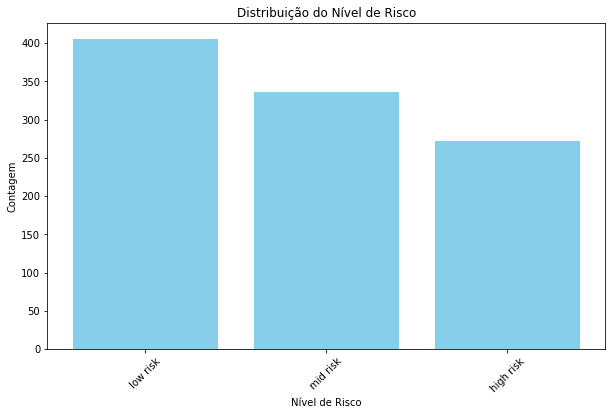

In [12]:
import matplotlib.pyplot as plt

# Criação do gráfico
plt.figure(figsize=(10, 6))
plt.bar(risk_level_distribution['RiskLevel'], risk_level_distribution['Count'], color='skyblue')
plt.xlabel('Nível de Risco')
plt.ylabel('Contagem')
plt.title('Distribuição do Nível de Risco')
plt.xticks(rotation=45)
plt.show()

In [13]:
from pyspark.sql.functions import col, count, when

# número de valores faltantes por coluna
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----------+-----------+---+--------+---------+---------+
|Age|SystolicBP|DiastolicBP| BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+---+--------+---------+---------+
|  0|         0|          0|  0|       0|        0|        0|
+---+----------+-----------+---+--------+---------+---------+



In [14]:
pressure_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(SystolicBP) AS AvgSystolicBP, 
    AVG(DiastolicBP) AS AvgDiastolicBP 
FROM rawdata 
GROUP BY RiskLevel
""").toPandas()

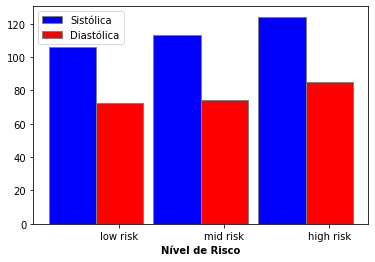

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Largura das barras
barWidth = 0.45

# Configurando a posição das barras
r1 = np.arange(len(pressure_risk['RiskLevel']))
r2 = [x + barWidth for x in r1]

# Criando as barras
plt.bar(r1, pressure_risk['AvgSystolicBP'], color='blue', width=barWidth, edgecolor='grey', label='Sistólica')
plt.bar(r2, pressure_risk['AvgDiastolicBP'], color='red', width=barWidth, edgecolor='grey', label='Diastólica')

# Adicionando legendas às barras
plt.xlabel('Nível de Risco', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(pressure_risk['RiskLevel']))], pressure_risk['RiskLevel'])

# Criando a legenda e mostrando o gráfico
plt.legend()
plt.show()


Este código primeiro configura o ambiente de plotagem determinando a largura das barras e a posição delas no gráfico. Depois, plota duas séries de dados: uma para a pressão sistólica média e outra para a diastólica média, cada uma associada a um nível de risco diferente. A legenda e os rótulos dos eixos ajudam a tornar o gráfico mais legível.

Esse gráfico proporcionará uma visualização clara das diferenças nas médias de pressão sistólica e diastólica entre os diferentes níveis de risco. Se precisar de mais ajuda ou tiver outras perguntas, estou aqui!

In [16]:
age_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(Age) AS AvgAge 
FROM rawdata 
GROUP BY RiskLevel
ORDER BY CASE 
    WHEN RiskLevel = 'low risk' THEN 1
    WHEN RiskLevel = 'mid risk' THEN 2
    WHEN RiskLevel = 'high risk' THEN 3
    ELSE 4
END
""").toPandas()

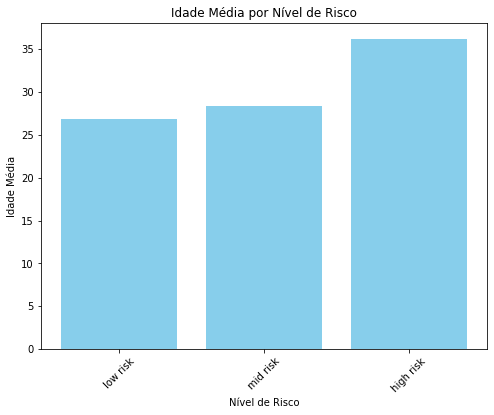

In [17]:
import matplotlib.pyplot as plt

# Criando o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(age_risk['RiskLevel'], age_risk['AvgAge'], color='skyblue')

# Adicionando títulos e rótulos
plt.title('Idade Média por Nível de Risco')
plt.xlabel('Nível de Risco')
plt.ylabel('Idade Média')
plt.xticks(rotation=45) # Rotação dos rótulos do eixo X para melhor leitura

# Mostrando o gráfico
plt.show()

Este gráfico oferece uma visualização clara de como a idade média varia entre os diferentes níveis de risco. Isso pode ajudar a identificar se há uma tendência de idade associada com o nível de risco.

- Rede Neural Artificial (ANN) utilizando TensorFlow/Keras 

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determinar o número de características de entrada
n_features = X_train_scaled.shape[1]

# Criar modelo sequencial
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(n_features,)))
model.add(Dense(8, activation='relu'))
# Se RiskLevel é binário usamos 1 neurônio de saída com sigmoid, caso contrário ajuste para multiclasse
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' e ajuste o número de neurônios se for multiclasse

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Ajuste conforme necessário

In [33]:
# Treinando o modelo
history = model.fit(X_train_scaled, y_train, epochs=140, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5670 - loss: -5724.9214 - val_accuracy: 0.5215 - val_loss: -8968.9521
Epoch 2/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5363 - loss: -6029.5269 - val_accuracy: 0.5215 - val_loss: -9023.9229
Epoch 3/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5557 - loss: -6492.8540 - val_accuracy: 0.5215 - val_loss: -9081.0381
Epoch 4/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5294 - loss: -6838.6309 - val_accuracy: 0.5215 - val_loss: -9140.2803
Epoch 5/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5719 - loss: -6495.8403 - val_accuracy: 0.5215 - val_loss: -9195.9297
Epoch 6/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5578 - loss: -6152.5918 - val_accuracy: 0.5215 - val_loss: -9250.5283
Epoch 7/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5900 - loss: -5414.0645 - val_accuracy: 0.5215 - val_loss: -9307.5029
Epoch 8/140
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

In [31]:
# Avaliando o modelo no conjunto de teste
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia no conjunto de teste: {accuracy:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5150 - loss: -4860.6411 
Acurácia no conjunto de teste: 0.5025


In [37]:
# Exemplo de previsão
# Lembre-se de normalizar os novos dados com o mesmo scaler usado anteriormente
new_data = np.array([[342, 150, 85, 13, 98, 75]])  # substitua '...' pelos valores reais
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
print(f'Previsão: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Previsão: [[1.]]


In [39]:
pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 491.2 kB/s eta 0:00:00 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units_hidden', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Ajuste da taxa de aprendizado
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [46]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Número máximo de combinações de hiperparâmetros a serem testadas
    executions_per_trial=2,  # Número de modelos a serem treinados e avaliados para cada tentativa
    directory='tuner_results',
    project_name='keras_tuner_demo'
)

Reloading Tuner from tuner_results/keras_tuner_demo/tuner0.json


In [47]:
tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=1)

In [48]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Avaliação do melhor modelo
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Acurácia do melhor modelo no conjunto de teste: {accuracy:.4f}')

print("Melhores hiperparâmetros:", best_hyperparameters.values)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5408 - loss: -95933.4375  
Acurácia do melhor modelo no conjunto de teste: 0.5320
Melhores hiperparâmetros: {'units_input': 64, 'units_hidden': 448, 'learning_rate': 0.01}


Ann outro metodo

In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Indexar o rótulo (label) se ele for categórico
indexer = StringIndexer(inputCol="RiskLevel", outputCol="label")
df = indexer.fit(df).transform(df)

# Assembler as características em um único vetor de características
assembler = VectorAssembler(inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"], outputCol="features")
data = assembler.transform(df)

# Dividindo os dados em conjuntos de treinamento e teste
train_data, test_data = data.randomSplit([0.7, 0.3])

In [51]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Definindo a arquitetura da rede neural
# O número de nós na camada de entrada deve ser igual ao número de características, e o número de nós na camada de saída deve ser igual ao número de classes.
# Neste exemplo, vamos supor 3 classes (riscos) e 6 características.
layers = [6, 5, 4, 3]

# Criando o classificador
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100)

In [52]:
# Treinando o modelo
model = mlp.fit(train_data)

2024-04-07 15:45:28,317 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2024-04-07 15:45:28,319 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Fazendo predições no conjunto de teste
predictions = model.transform(test_data)

# Avaliando a acurácia
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Acurácia: {accuracy}")

Acurácia: 0.5501618122977346


Passo 1: Preparação dos Dados
A preparação dos dados é crucial para o sucesso do treinamento do modelo. Isso inclui a limpeza de dados, a seleção de características relevantes, a normalização (quando necessário) e a divisão dos dados em conjuntos de treinamento e teste.

In [54]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.functions import col

# Certificando-se de que a coluna 'label' não cause conflito
if "label" in df.columns:
    df = df.drop("label")

# Indexação de rótulos categóricos com novo nome de coluna para evitar conflitos
indexer = StringIndexer(inputCol="RiskLevel", outputCol="indexedLabel").fit(df)
df_indexed = indexer.transform(df)

# Assembleia das características
assembler = VectorAssembler(
    inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"],
    outputCol="features")
df_assembled = assembler.transform(df_indexed)

# Normalização das características (opcional, mas recomendado)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

# Divisão dos dados
(train_data, test_data) = df_scaled.randomSplit([0.8, 0.2])

In [55]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Definindo a arquitetura da rede: número de nós na camada de entrada igual ao número de características; ajuste conforme necessário
layers = [6, 5, 4, 3]  # Exemplo: 6 características de entrada, duas camadas ocultas (5 e 4 neurônios), 3 saídas

mlp = MultilayerPerceptronClassifier(
    layers=layers,
    blockSize=128,
    seed=1234,
    maxIter=100,
    featuresCol="scaledFeatures",
    labelCol="indexedLabel")  # Ajuste para usar a coluna 'indexedLabel'

# Treinamento do modelo
model = mlp.fit(train_data)

# Avaliação do modelo
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Acurácia: {accuracy:.4f}")

Acurácia: 0.6170


In [56]:
import tensorflow as tf
from tensorflow import keras
from kerastuner import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                 activation='relu', input_shape=(num_features,)))
    model.add(keras.layers.Dense(3, activation='softmax'))  # Assumindo uma tarefa de classificação com 3 classes
    
    # Otimização de hiperparâmetros: taxa de aprendizado e escolha do otimizador
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    
    if hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Criando o objeto de busca do tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='keras_tuning'
)

NameError: name 'num_features' is not defined

Neste exemplo, build_model é uma função que constrói um modelo Keras. Ela usa o objeto hp (de hiperparâmetros) do keras-tuner para explorar diferentes valores de unidades na camada oculta, taxas de aprendizado e otimizadores. O keras-tuner então busca no espaço de hiperparâmetros fornecido para encontrar a melhor combinação de acordo com a acurácia de validação.